In [110]:
using Revise

In [111]:
using PyCall, PyPlot
using ClimateMARGO
inset_locator = pyimport("mpl_toolkits.axes_grid.inset_locator");
mpl = pyimport("matplotlib");
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams");

In [112]:
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Utils
using ClimateMARGO.Optimization
using ClimateMARGO.IO

### Replicating Belaia, Moreno-Cruz, and Keith (2020 preprint) results

Loading in the default model parameters

In [113]:
params = deepcopy(included_configurations["default"])

ClimateModelParameters("default", Domain(5.0, 2020.0, 2020.0, 2200.0), Economics(100.0, 0.02, 0.0022222222222222222, 0.02, 8.5, 0.034, 13.0, 0.126, 4.5, 0, 0, 0, nothing, [7.5, 8.4375, 9.375, 10.3125, 11.25, 12.1875, 13.125, 14.0625, 15.0, 15.9375  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), Physics(460.0, 1.1, 4.977297891066924, 1.13, 106.0, 0.73, 0.5))

#### Modifications to match Belaia et al. DICE configuration

In [114]:
# Shorter timestep, longer timeframe
params.domain.final_year = 2500.

# Modify baseline emissions scenario (Figure 4 https://arxiv.org/abs/1903.02043)
function baseline_emissions_Belaia(params)
    q = zeros(size(t(params)))
    q[t(params).<=2120.] = (
        GtCO2_to_ppm(75.) .- GtCO2_to_ppm(40.) * ( (t(params)[t(params).<=2120.] .- 2120.) ./ 100.).^2
    )
    q[t(params).>2120.] = (
        GtCO2_to_ppm(75.) .- GtCO2_to_ppm(30.) * ( (t(params)[t(params).>2120.] .- 2120.) ./ 130.).^2.
    )
    q[q .< 0] .= 0.
    return q
end
params.economics.baseline_emissions = baseline_emissions_Belaia(params);

params.name = "Belaia_et_al_2020";

In [115]:
Belaia = ClimateModel(params);

#### Modifications to optimization constraints

In [154]:
# Remove limit on how early deployments can be
delay_deployment=Dict("remove"=>0., "mitigate"=>0., "geoeng"=>0., "adapt"=>0.)

# Modify cost functions exponents
cost_exponent = Dict("mitigate" => 2, "geoeng" => 2., "adapt" => 0., "remove" => 1.1)

# Much higher intertia in deployment rates, except geoengineering which has virtually no limit
slope = 1. /100
max_slope = Dict("mitigate" => slope, "geoeng" => 1., "adapt" => slope, "remove" => slope);

## Run optimization

In [155]:
Belaia = ClimateModel(params);
optimize_controls!(
    Belaia,
    obj_option = "net_benefit",
    max_deployment=Dict("remove"=>1., "mitigate"=>1., "geoeng"=>1., "adapt"=>0.), # no adaptation
    delay_deployment=delay_deployment,
    max_slope = max_slope,
    cost_exponent=cost_exponent
);

Belaia_MR = ClimateModel(deepcopy(params));
optimize_controls!(
    Belaia_MR,
    obj_option = "net_benefit",
    max_deployment=Dict("remove"=>1., "mitigate"=>1., "geoeng"=>0., "adapt"=>0.), # no adaptation or geoengineering
    delay_deployment=delay_deployment,
    max_slope = max_slope,
    cost_exponent=cost_exponent
);

Belaia_M = ClimateModel(deepcopy(params));
optimize_controls!(
    Belaia_M,
    obj_option = "net_benefit",
    max_deployment=Dict("remove"=>0., "mitigate"=>1., "geoeng"=>0., "adapt"=>0.), # no adaptation or geoengineering
    delay_deployment=delay_deployment,
    max_slope = max_slope,
    cost_exponent=cost_exponent
);

Belaia_MG = ClimateModel(deepcopy(params));
optimize_controls!(
    Belaia_MG,
    obj_option = "net_benefit",
    max_deployment=Dict("remove"=>0., "mitigate"=>1., "geoeng"=>1., "adapt"=>0.), # no adaptation or geoengineering
    delay_deployment=delay_deployment,
    max_slope = max_slope,
    cost_exponent=cost_exponent
);

Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded


#### Replicate Figures

In [156]:
using ClimateMARGO.Plotting

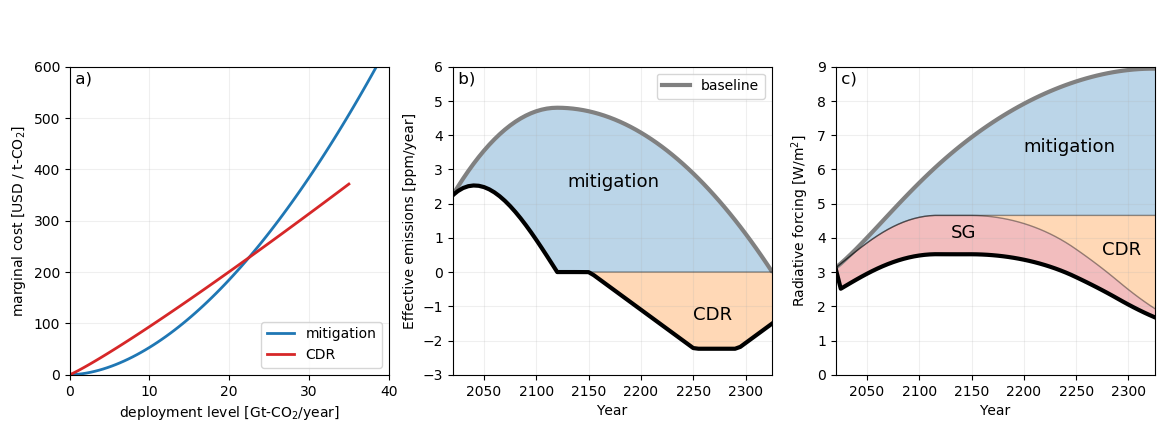

In [190]:
figure(figsize=(14,4))
## Figure 2

subplot(1,3,1)
α = collect(0:0.01:1.)
function marginal_cost_M(year)
    yearidx = t(params) .== year
    return (
        (10^12 * E(params)[yearidx]*params.economics.mitigate_cost .* α.^1.8) /
        ppm_to_tCO2(params.economics.baseline_emissions)[yearidx]
    )
end

function marginal_cost_R(year)
    yearidx = t(params) .== year
    return (
        (10^12 * params.economics.remove_cost .* α.^1.1) /
        ppm_to_tCO2(params.economics.baseline_emissions[1])
    )
end

for year in [2175.]   
    plot(ppm_to_GtCO2(params.economics.baseline_emissions[1])*α*1.5, marginal_cost_M(year), lw=2., "C0-", label="mitigation")
    plot(ppm_to_GtCO2(params.economics.baseline_emissions[1])*α, marginal_cost_R(year), lw=2., "C3-", label="CDR")
end
legend(loc="lower right")
title(" a)", loc="left", y=0.92)
xlim([0,40])
ylim([0, 600])
xlabel(L"deployment level [Gt-CO$_{2}$/year]")
ylabel(L"marginal cost [USD / t-CO$_{2}$]")
grid(true, alpha=0.2)

## Emisisons

subplot(1,3,2)
F0 = 3.0
fill_between(t(params), effective_emissions(Belaia), effective_emissions(Belaia, M=true), facecolor="C0", alpha=0.3)
fill_between(t(params), effective_emissions(Belaia, M=true), effective_emissions(Belaia, M=true, R=true), facecolor="C1", alpha=0.3)
plot(t(params), effective_emissions(Belaia), "-", color="grey", lw=3, label="baseline")
plot(t(params), effective_emissions(Belaia, M=true), "k-", lw=1, alpha=0.4)
plot(t(params), effective_emissions(Belaia, M=true, R=true), "k-", lw=3)
legend()
annotate(s="mitigation", xy=(2130, 2.5), fontsize=13)
annotate(s="CDR", xy=(2250, -1.4), fontsize=13)
ylim([-3, 6])
xlim([2020, 2325])
ylabel("Effective emissions [ppm/year]")
xlabel("Year")
grid(true, alpha=0.2)
title(" b)", loc="left", y=0.92)

## Figure 3b

subplot(1,3,3)
F0 = 3.0
fill_between(t(params), F(Belaia, F0=F0), F(Belaia, M=true, F0=F0), facecolor="C0", alpha=0.3)
fill_between(t(params), F(Belaia, M=true, F0=F0), F(Belaia, M=true, R=true, F0=F0), facecolor="C1", alpha=0.3)
fill_between(t(params), F(Belaia, M=true, R=true, F0=F0), F(Belaia, M=true, R=true, G=true, F0=F0), facecolor="C3", alpha=0.3)
plot(t(params), F(Belaia, F0=F0), "-", color="grey", lw=3, label="baseline")
plot(t(params), F(Belaia, M=true, F0=F0), "k-", lw=1, alpha=0.4)
plot(t(params), F(Belaia, M=true, R=true, F0=F0), "k-", lw=1, alpha=0.4)
plot(t(params), F(Belaia, M=true, R=true, G=true, F0=F0), "k-", lw=3)
ylim([0, 9])
xlim([2020, 2325])
ylabel(L"Radiative forcing [W/m$^2$]")
xlabel("Year")
grid(true, alpha=0.2)
title(" c)", loc="left", y=0.92)

annotate(s="mitigation", xy=(2200, 6.5), fontsize=13)
annotate(s="CDR", xy=(2275, 3.5), fontsize=13)
annotate(s="SG", xy=(2130, 4.0), fontsize=13)
annotate(s="Simple quadratic SG", xy=(2040, 10.25), fontsize=13)

savefig("figures/replicate_Belaia_et_al_2020_Figure3b.png", dpi=200., bbox_inches="tight")

In [160]:
println("All results reported in trillions of USD.")

for ρ in [0.015, 0.03]
    println("ρ = $(ρ*100) discount rate")
    for (model, modelname) in zip([Belaia, Belaia_MR], ["MRG", "MR"])
        println("  Allowed controled: $(modelname)")
        model.economics.ρ = ρ
        println("    Integrated discounted control costs = $(round(sum(cost(model, discounting=true, M=true, R=true, G=true))))")
        println("    Integrated discounted controlled damages = $(round(sum(damage(model, discounting=true, M=true, R=true, G=true))))")
        net_costs = sum(cost(model, discounting=true, M=true, R=true, G=true) .+ damage(model, discounting=true, M=true, R=true, G=true))
        println("    Total integrated discounted costs (controls + damages) = $(round(net_costs))")
        println("    Integrated discounted baseline damages = $(round(sum(damage(model, discounting=true))))")
        println("    Net present benefits (cost + damage) relative to baseline damages = $(round(net_present_benefit(model, discounting=true, M=true, R=true, G=true)))")
    end
end

All results reported in trillions of USD.
ρ = 1.5 discount rate
  Allowed controled: MRG
    Integrated discounted control costs = 39.0
    Integrated discounted controlled damages = 40.0
    Total integrated discounted costs (controls + damages) = 78.0
    Integrated discounted baseline damages = 2473.0
    Net present benefits (cost + damage) relative to baseline damages = 11975.0
  Allowed controled: MR
    Integrated discounted control costs = 23.0
    Integrated discounted controlled damages = 80.0
    Total integrated discounted costs (controls + damages) = 103.0
    Integrated discounted baseline damages = 2473.0
    Net present benefits (cost + damage) relative to baseline damages = 11849.0
ρ = 3.0 discount rate
  Allowed controled: MRG
    Integrated discounted control costs = 6.0
    Integrated discounted controlled damages = 6.0
    Total integrated discounted costs (controls + damages) = 12.0
    Integrated discounted baseline damages = 43.0
    Net present benefits (cost +